# Test file

## Imports

In [1]:
# MLflow
import mlflow
from mlflow.models import infer_signature

# MLflow model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualizations
import matplotlib.pyplot as plt

# math functions
import numpy as np

## Load training data

In [2]:
# read CSV file
import os
import glob

# data frames
import pandas as pd

# regexes
import re

# future warnings
import warnings
warnings.filterwarnings("ignore")

# Use the Kickstarter dataset
"""
    ['backers_count', 'blurb', 'category', 'converted_pledged_amount', 'country', 'country_displayable_name', 
    'created_at', 'creator', 'currency', 'currency_symbol', 'currency_trailing_code', 'current_currency', 'deadline', 
    'disable_communication', 'fx_rate', 'goal', 'id', 'is_disliked', 'is_launched', 'is_liked', 'is_starrable', 
    'launched_at', 'location', 'name', 'percent_funded', 'photo', 'pledged', 'prelaunch_activated', 'profile', 
    'slug', 'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at', 'static_usd_rate', 'urls', 
    'usd_exchange_rate', 'usd_pledged', 'usd_type', 'video']
"""
df = pd.DataFrame()
df_files = {}
running_total = 0
for fname in glob.glob(os.path.abspath('./data/**/*.csv')):
    _df=pd.read_csv(fname)
    df = df.append(_df.copy(), ignore_index=True)
    df_files[os.path.basename(fname)] = _df
    running_total+=len(_df)
    print(fname)
    print(running_total)
    #break #DEBUG

# US-only, because keywords are in English
"""
df = df[df['country'] == 'US']
print(len(df))
df = df[df['category'].str.contains('"parent_name":"Technology"')]
print(len(df))
"""

# List of regular expressions for search terms
search_terms = []
search_acronyms = ['ai','ml','nlp']
search_words = ['artificial intelligence', 'neural networks', 'computer vision', 'natural language processing', 'deep learning',
                'Tensorflow','robotics', 'chatbot', 'Augmented Reality', 'Speech Generation']
for term in search_acronyms:
    pattern = r'[ (]' + ''.join([f'{char}[.]?' for char in term]) + r'[ ,.)]'
    search_terms.append(pattern)
for term in search_words:
    pattern = re.sub(r'(\s|-)', r'[ -]?', term)
    search_terms.append(pattern)
regex_patterns = [re.compile(term, re.IGNORECASE) for term in search_terms]

# building ai_mention field
search_columns = ['blurb','name']
for column in search_columns:
    df['ai_matches_' + column] = df[column].apply(lambda text: [pattern.search(str(text).lower()).group() for pattern in regex_patterns if pattern.search(str(text).lower())] or None)
    df['ai_mention_' + column] = df['ai_matches_' + column].apply(lambda x: x is not None)
df['ai_mention'] = df[['ai_mention_' + column for column in search_columns]].any(axis=1)


c:\Users\georg\Documents\GitHub\mlflow\data\Kickstarter_2023-01-05T03_20_04_136Z\Kickstarter.csv
3659
c:\Users\georg\Documents\GitHub\mlflow\data\Kickstarter_2023-01-05T03_20_04_136Z\Kickstarter001.csv
7349
c:\Users\georg\Documents\GitHub\mlflow\data\Kickstarter_2023-01-05T03_20_04_136Z\Kickstarter002.csv
7432
c:\Users\georg\Documents\GitHub\mlflow\data\Kickstarter_2023-02-16T03_20_05_221Z\Kickstarter.csv
11078
c:\Users\georg\Documents\GitHub\mlflow\data\Kickstarter_2023-02-16T03_20_05_221Z\Kickstarter001.csv
11825
c:\Users\georg\Documents\GitHub\mlflow\data\Kickstarter_2023-03-09T03_20_04_199Z\Kickstarter.csv
15405
c:\Users\georg\Documents\GitHub\mlflow\data\Kickstarter_2023-04-18T13_03_17_223Z\Kickstarter.csv
19045
c:\Users\georg\Documents\GitHub\mlflow\data\Kickstarter_2023-04-18T13_03_17_223Z\Kickstarter001.csv
22739
c:\Users\georg\Documents\GitHub\mlflow\data\Kickstarter_2023-04-18T13_03_17_223Z\Kickstarter002.csv
26425
c:\Users\georg\Documents\GitHub\mlflow\data\Kickstarter_2023-

In [6]:
# Debugging
pd.set_option('display.max_rows', 3)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
#df.info()
total = len(df.index)
ai_mentions = df.loc[df['ai_mention'] == True].shape[0]
print(f"{ai_mentions}(ai_mentions)/{total}(total) = {ai_mentions/total}")
#df.loc[df['ai_mention_blurb'] == True, ['name', 'blurb', 'ai_mention', 'ai_matches_blurb', 'ai_matches_name']]
df


3669(ai_mentions)/648395(total) = 0.00565858774358223


,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,...,is_launched,is_liked,percent_funded,prelaunch_activated,video,ai_matches_blurb,ai_mention_blurb,ai_matches_name,ai_mention_name,ai_mention
0,12,A kung fu master gets canceled for defeating an Asian challenger because the victory is mistaken for a hate crime.,"{""id"":292,""name"":""Comedy"",""analytics_name"":""Comedy"",""slug"":""film & video/comedy"",""position"":3,""parent_id"":11,""parent_name"":""Film & Video"",""color"":16734574,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/film%20&%20video/comedy""}}}",619.0,US,the United States,1672609702,"{""id"":584593596,""name"":""Michael J Kospiah"",""slug"":""michaeljkospiah"",""is_registered"":null,""is_email_verified"":null,""chosen_currency"":null,""is_superbacker"":null,""avatar"":{""thumb"":""https://ksr-ugc.imgix.net/assets/039/567/599/c5aa2167684a9ee5bd155ace2ed61f34_original.jpg?ixlib=rb-4.0.2&w=40&h=40&fit=crop&v=1672623580&auto=format&frame=1&q=92&s=8971b6dc8e555d4283ff4cc9281eebb5"",""small"":""https://ksr-ugc.imgix.net/assets/039/567/599/c5aa2167684a9ee5bd155ace2ed61f34_original.jpg?ixlib=rb-4.0.2&w=80&h=80&fit=crop&v=1672623580&auto=format&frame=1&q=92&s=b77a8c514720dc8442beab8ea2f07a73"",""medium"":""https://ksr-ugc.imgix.net/assets/039/567/599/c5aa2167684a9ee5bd155ace2ed61f34_original.jpg?ixlib=rb-4.0.2&w=160&h=160&fit=crop&v=1672623580&auto=format&frame=1&q=92&s=f176e9b7f83fce8d726c90ea6fa2f160""},""urls"":{""web"":{""user"":""https://www.kickstarter.com/profile/michaeljkospiah""},""api"":{""user"":""https://api.kickstarter.com/v1/users/584593596?signature=1672975215.9522df02a7f3860584bd472dfca7193dba9d83c7""}}}",USD,$,...,NaN,NaN,NaN,NaN,NaN,None,False,None,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648394,4,"I’m trying to put on a production of my self-published One Person Show, called bohemia. in my new hometown of San Francisco.","{""id"":285,""name"":""Plays"",""analytics_name"":""Plays"",""slug"":""theater/plays"",""position"":6,""parent_id"":17,""parent_name"":""Theater"",""color"":16743775,""urls"":{""web"":{""discover"":""http://www.kickstarter.com/discover/categories/theater/plays""}}}",94.0,US,the United States,1563277539,"{""id"":1440094950,""name"":""Ellie M. Bruner-Welch"",""is_registered"":null,""is_email_verified"":null,""chosen_currency"":null,""is_superbacker"":null,""avatar"":{""thumb"":""https://ksr-ugc.imgix.net/assets/025/822/978/ad28079489c32ac2f9e706f3f7f7b9c4_original.jpeg?ixlib=rb-4.1.0&w=40&h=40&fit=crop&v=1563278810&auto=format&frame=1&q=92&s=457104a01b15c6cd59a4b0e09b45deab"",""small"":""https://ksr-ugc.imgix.net/assets/025/822/978/ad28079489c32ac2f9e706f3f7f7b9c4_original.jpeg?ixlib=rb-4.1.0&w=80&h=80&fit=crop&v=1563278810&auto=format&frame=1&q=92&s=0ab8a0225d397a2215a5c9e7c5e6dec9"",""medium"":""https://ksr-ugc.imgix.net/assets/025/822/978/ad28079489c32ac2f9e706f3f7f7b9c4_original.jpeg?ixlib=rb-4.1.0&w=160&h=160&fit=crop&v=1563278810&auto=format&frame=1&q=92&s=428f8c8d97ac3c30743ee980c8ae1664""},""urls"":{""web"":{""user"":""https://www.kickstarter.com/profile/1440094950""},""api"":{""user"":""https://api.kickstarter.com/v1/users/1440094950?signature=1705414757.89f67d9d7348f7b6f3a4eb601bb15fd2941e04a0""}}}",USD,$,...,True,False,15.666667,False,NaN,None,False,None,False,False


In [10]:
# Convert all numeric columns to numeric type
numeric_columns = df.select_dtypes(include='number').columns
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Remove NA items
df.replace([np.inf, -np.inf], np.nan, inplace=True)
feature_names = ['backers_count','spotlight','staff_pick','percent_funded', 'is_disliked', 'is_launched', 'is_liked', 'is_starrable', 'goal']
df.dropna(subset=feature_names, how="any", inplace=True)
target_name = 'ai_mention'
df.dropna(subset=target_name, how="any", inplace=True)
X = df.loc[:, df.columns[:,None] == feature_names]
y = df.loc[:, df.columns == target_name].values
print(f"{ai_mentions}(ai_mentions)/{total}(total) = {ai_mentions/total}")

3669(ai_mentions)/648395(total) = 0.00565858774358223


In [11]:
# MLflow model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer as imp

# Enable automatic logging to MLflow
mlflow.set_experiment("MLflow")
mlflow.autolog()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

rf_params = {'n_estimators':100, 'max_depth':6, 'max_features':3}
logr_params = {}
lr_params = {}

# Train the model
rf = RandomForestRegressor(**rf_params)

# MLflow triggers logging automatically upon model fitting
rf.fit(X_train, y_train)

# Predict on the test set
rf_y_pred = rf.predict(X_test)

logr = LogisticRegression(**logr_params)

# MLflow triggers logging automatically upon model fitting
logr.fit(X_train, y_train)

# Predict on the test set
logr_y_pred = logr.predict(X_test)

lr = LinearRegression(**lr_params)

# MLflow triggers logging automatically upon model fitting
lr.fit(X_train, y_train)

# Predict on the test set
lr_y_pred = lr.predict(X_test)

2024/02/16 10:47:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/02/16 10:47:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '776149fe81b94a9380b98e4e446680ad', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/16 10:47:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '38af52a59bae4878b92cb90f0a6c0b5d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/16 10:47:32 WARNING mlflow.sklearn.utils: Failed to autolog artifacts for LogisticRegression. Logging error: unhashable type: 'numpy.ndarray'
2024/02/16 10:47:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1788518449da478f82b91a6fd523657c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for t

## Random Forest

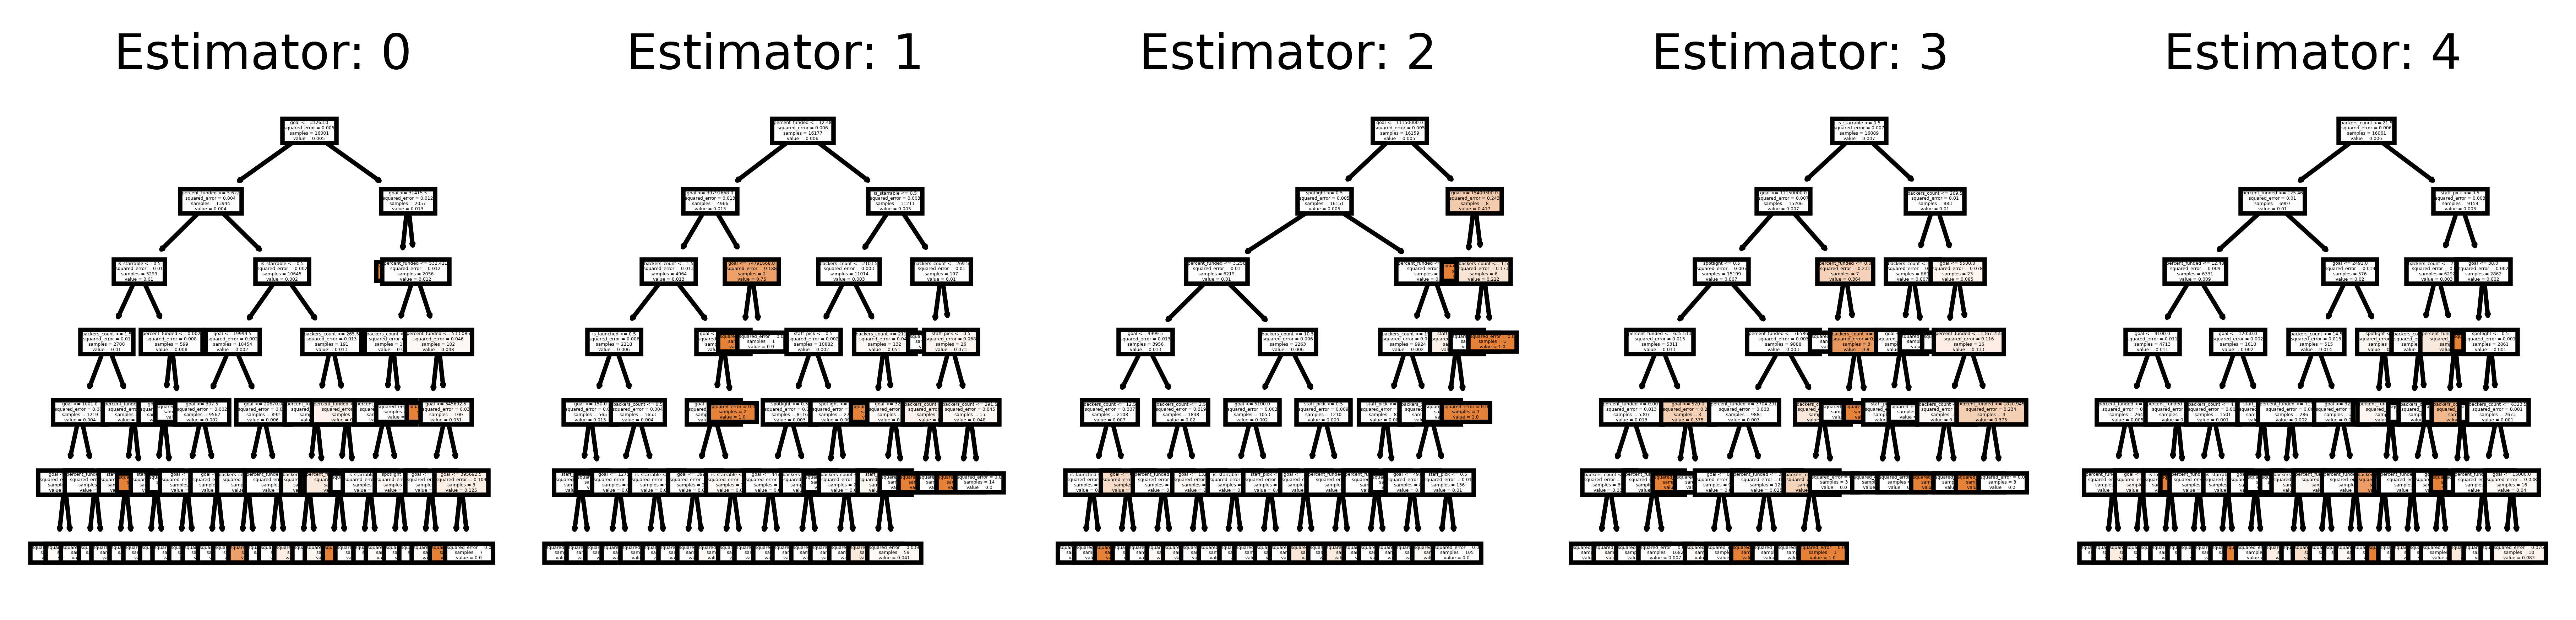

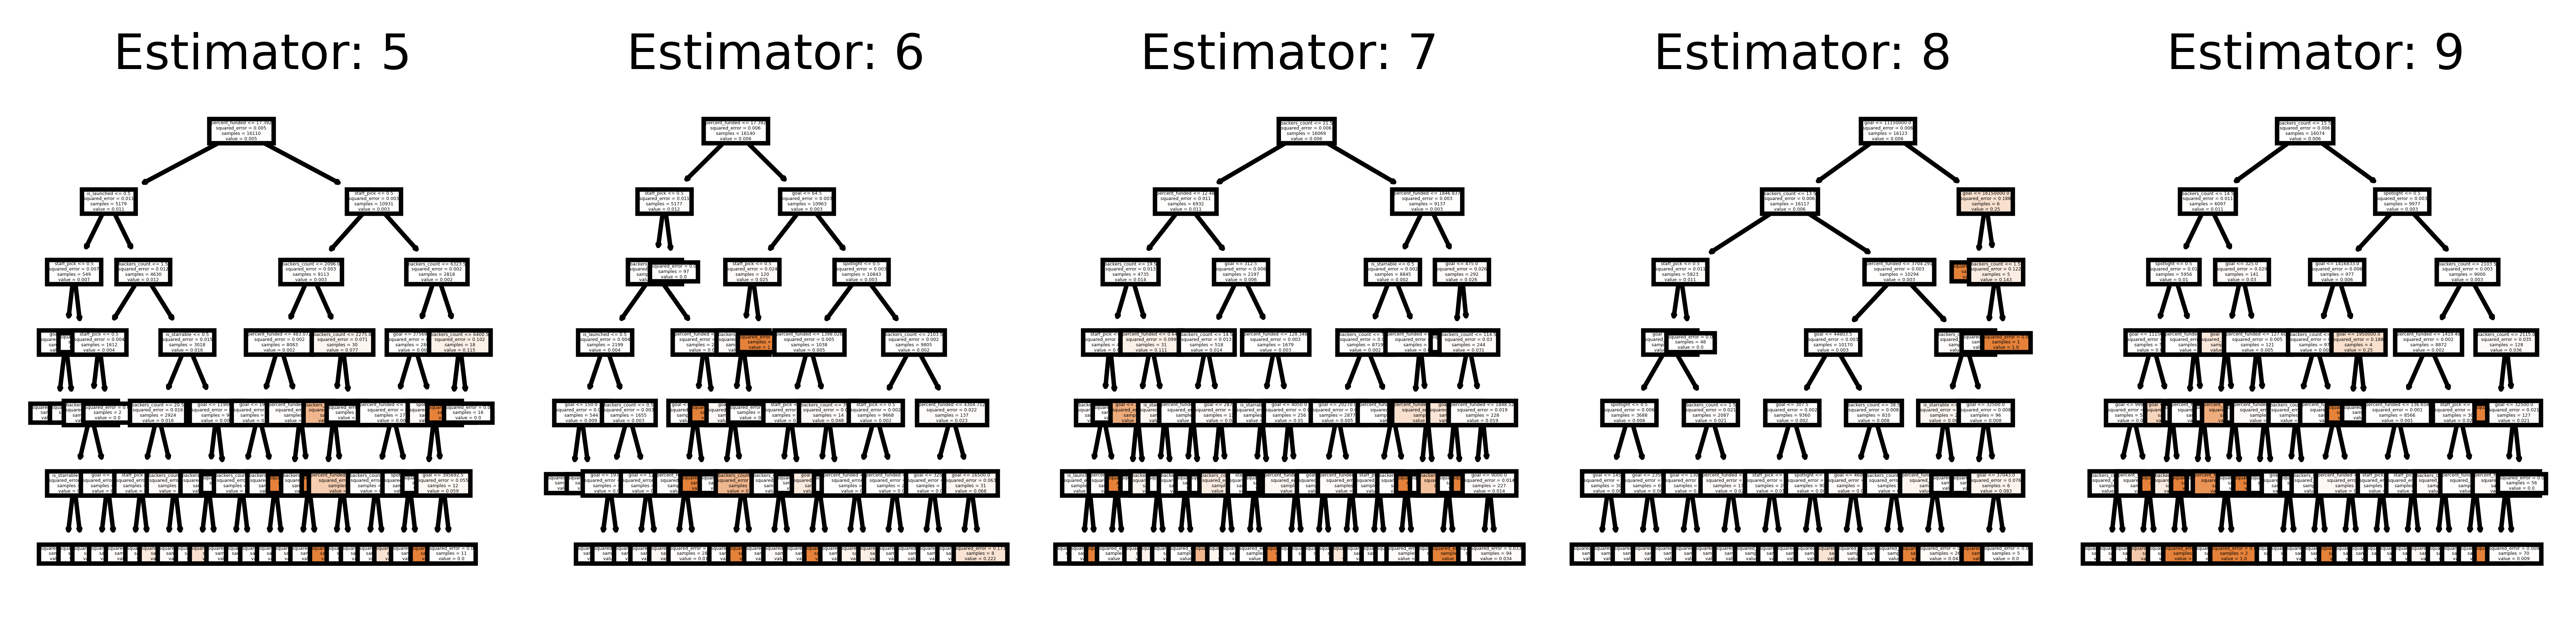

In [12]:
from sklearn import tree
fn=X_train.columns
cn=target_name
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(rf.estimators_[index],
        feature_names = fn,
        class_names=cn,
        filled = True,
        ax = axes[index])
    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)

fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
next = 5
for index in range(0+next, 5+next):
    axes_idx = index - next
    tree.plot_tree(rf.estimators_[index],
        feature_names = fn,
        class_names=cn,
        filled = True,
        ax = axes[axes_idx])
    axes[axes_idx].set_title('Estimator: ' + str(index), fontsize = 11)



0.012518699280011147


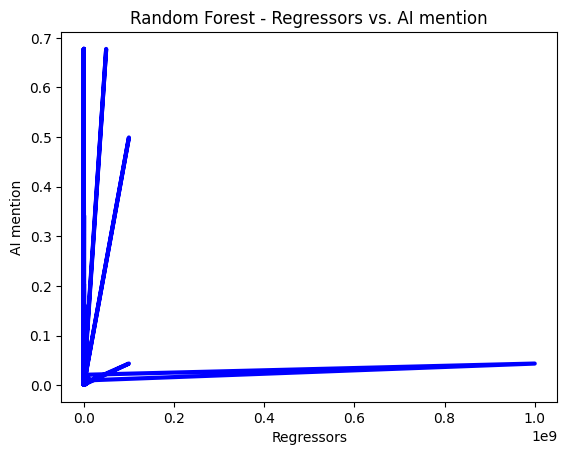

In [13]:
accuracy = mean_absolute_error(y_test, rf_y_pred)
print(accuracy)
#plt.scatter(X_train, y_train, color='red')
plt.plot(X_test, rf_y_pred, color='blue', linewidth=3)
plt.xlabel('Regressors')
plt.ylabel('AI mention')
plt.title('Random Forest - Regressors vs. AI mention')
plt.show()

## Logistic Regression

In [26]:
X_train[feature_names]

,backers_count,spotlight,staff_pick,percent_funded,is_disliked,is_launched,is_liked,is_starrable,goal
601924,31,True,False,100.925926,False,True,False,False,2700.0
...,...,...,...,...,...,...,...,...,...
600258,6,False,False,8.108108,False,True,False,False,3700.0


In [32]:
logr.coef_

array([[ 9.91962692e-06,  2.97211215e-09, -3.39577244e-01,
        -4.44032463e-01, -3.87548496e-02,  0.00000000e+00,
        -2.36819125e+00,  0.00000000e+00,  4.39106556e-06]])

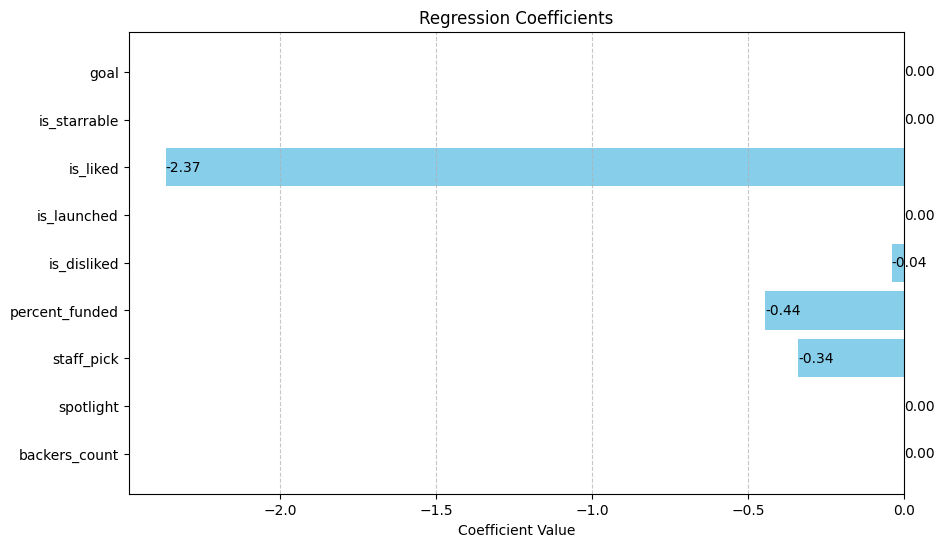

In [37]:
logr_coefficients = logr.coef_[0]  # Obtain the coefficients

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.barh(range(len(logr_coefficients)), logr_coefficients, color='skyblue')
# Add labels to the bars
for i, coef in enumerate(logr_coefficients):
    plt.text(coef, i, f'{coef:.2f}', ha='left', va='center', color='black', fontsize=10)

# Set y-axis labels and ticks
plt.yticks(range(len(feature_names)), feature_names)

plt.xlabel('Coefficient Value')
plt.title('Regression Coefficients')
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.show()

## Linear Regression

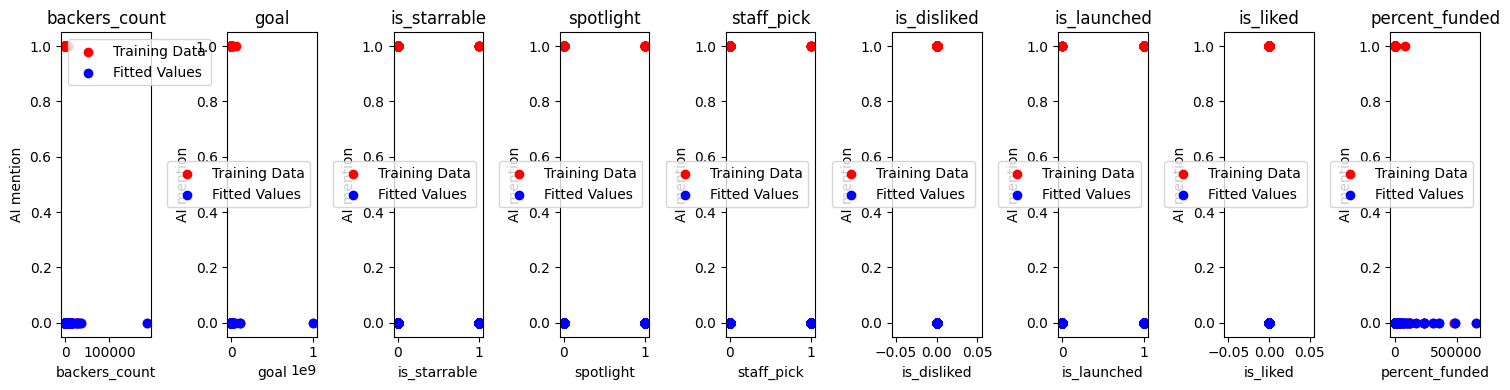

In [ ]:
# Plot the scatter plot of the training data along with the fitted values for each feature
num_features = X_train.shape[1]
fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(15, 4))  # Adjust figsize as needed

for i in range(num_features):
    feature_name = X_train.columns[i]
    axes[i].scatter(X_train.iloc[:, i], y_train, color='red', label='Training Data')
    axes[i].scatter(X_test.iloc[:, i], lr_y_pred, color='blue', label='Fitted Values')
    axes[i].set_xlabel(feature_name)
    axes[i].set_ylabel('AI mention')
    axes[i].set_title(f'{feature_name}')
    axes[i].legend()

plt.tight_layout()
plt.show()